# An introduction to neural networks

For a long time, neural networks were like a black box for me. I knew that they could do great things, but I had no idea how they did it. So I decided to do what I often do in that case and build one on my own from the ground up. It took me a bit and quite some reading, but I succeeded, and it was like someone pulled a curtain away. I will try to distill everything I learned along the way in this notebook. It might be a bit theoretical sometimes, but at least for me, it really helped a lot to get some basic understanding of the inner functionality of neural networks. When applying neural networks, things rarely go smooth on the first try, and understanding where an error might come from and what you can do to fix it can be very helpful.

This is not about knowing all the painful details but more about getting a feeling for neural networks, what parts they are made of, and how they play together. So don't worry if you don't understand everything or if all of this looks like total gibberish to you. If you want to, you can take this as a starting point to dive into the math behind neural nets, which can be very interesting and also satisfying once you really get it. But, again, this is absolutely not necessary. If you have a general understanding of what neural nets can do and how they do it, then I succeeded :)

In [1]:
from jupyter_core.paths import jupyter_config_dir
jupyter_dir = jupyter_config_dir()
import os.path
custom_js_path = os.path.join(jupyter_dir, 'custom', 'custom.js')
print("searching for custom.js in ", custom_js_path)
#  my custom js
if os.path.isfile(custom_js_path):
    with open(custom_js_path) as f:
        print(f.read())
else:
    print("You don't have a custom.js file")

searching for custom.js in  /Users/fishfang/.jupyter/custom/custom.js
You don't have a custom.js file


We will be building a neural net from scratch in this notebook! No pre-build machine learning libraries like TensorFlow, Keras, or PyTorch, we will code a fully functional neural net on our own, from one end to the other. It will be capable of identifying handwritten digits - but you can extend it to many different tasks. This may sound like a daunting task at first, but trust me, it is not that complicated. 

**So let's dive into it!**

## Preperation

First, please run this cell. It will just copy a file that contains some helper code into your workspace. The code in there doesn't do much; it is mainly just a couple of print() statements and some data preparation. It contains no logic necessary for the neural net. I just moved some code there to keep the notebook clear and concise.

In [1]:
!git clone https://github.com/aschwersenz/nn_introduction.git

Cloning into 'nn_introduction'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 66 (delta 1), reused 8 (delta 1), pack-reused 57
Unpacking objects: 100% (66/66), done.


Although we won't be using any machine learning libraries and will be build everything ourselves, we still need some external libraries to help us out with some things.

In [5]:
import numpy as np # numpy is a library that will help us with some math involved later.
import time # time is handy to check how long our neural net takes to learn something.
from matplotlib import pyplot as plt # We will classify images, so this is a library to display images.
from nn_introduction.helperfunc import print_network_info, print_epoch_info, load_mnist # These are the aboved mentioned helper functions that I outsourced.
import random # We will need some random numbers from time to time.

%matplotlib inline 

As our example dataset, we will use the MNIST dataset. This dataset consists of thousands of handwritten single digits as black and white 28 x 28-pixel images. It is kind of the "hello world" dataset for machine learning; nearly everybody started there. It contains 60.000 images to train your neural net and 10.000 images to test afterward how good your neural net is doing. Separating your data into two sets, one for training and one for testing, is considered best practice. We split the data to later have a "neutral" data set to test our neural network that the network did not see before during training. This way, we can test if our neural network generalizes well to new, never-before-seen data. For now, there is a function among these helper functions called $load\_mnist()$ that will return these two datasets.

Let's take a look at some of those images:

11493376/11490434 [==============================] - 2s 0us/step


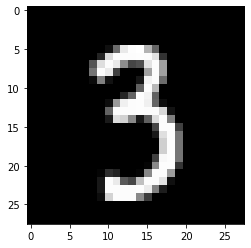

In [6]:
train_images, test_images = load_mnist()

image = 98 # Change this index to display different images.

plt.imshow(train_images[image][0].reshape((28, 28)), cmap='gray')

## A neural network - 101

So what can a neural net really do?

**Well, at its heart, a neural net is just a function that takes as an input a vector or a matrix and outputs another vector or matrix.** So it can take in a column or table of numbers and output a new column or table of numbers.

In this example, we will only work with vectors, so our network can basically do something like this:

 >$
\begin{equation*}
\begin{pmatrix}
128\\
196\\
255\\
255\\
199\\
\vdots \\
\vdots \\
\vdots \\
201\\
203\\
255\\
255\\
196
\end{pmatrix}\rightarrow f( x)\rightarrow \ \begin{pmatrix}
0\\
0\\
1\\
0\\
0\\
0\\
0\\
0\\
0\\
0
\end{pmatrix}
\end{equation*}$
 
That's all. This may sound a bit disappointing at first. Eventually, we want to create pictures, detect dogs and cats and identify people. But actually, that is very powerful because it is a very generic data format. All we have to do is think a bit about how we can transform our desired input and output data into this format.

Let's take our example of identifying handwritten digits.

As input, we have a black and white image. We are only working with vectors in this example, so we have to find a way to transform the image into a vector. Representing a black and white image as numbers is relatively easy. We just represent each pixel with a number between 0 (black) and 255 (white). To transform the image now into a vector, we just take the pixel values of all columns of the picture and stack them on top of each other. A 28 x 28 image consists of 28 vectors, each containing the pixels of one column of the picture, and by stacking them up, we get a vector of the length 28 x 28 = 784. By doing so, we lose some spatial information, but our neural network can deal with that.

As output, we have 10 different classes, one for each number between 0 and 9. So we could use a vector with 10 entries and set all entries to 0 except for the index of the number we are looking for, which we set to 1.

By doing this, we have transformed the input and the output for our neural net into a vector.

>![](https://github.com/aschwersenz/nn_introduction/raw/master/images/vec2vec.png)

As mentioned above, neural networks can also process matrices. This makes more sense for images, as an image is by its nature already a matrix with the dimensions *pixel width* x *pixel height* x *color channels*. (e.g., 1024 x 768 x 3 for an RGB image or 1024 x 768 x 1 for a black and white picture). Then we can skip the step where we stack the column vectors. This is how images are usually processed in a neural network. Suppose you want to transform one image into another (e.g., for colorizing). In that case, you take a matrix at both ends of the neural network. But handling matrices requires a different kind of neural network, which we will not cover today, so we will stick with vectors for now.

It is sometimes not that obvious for other data types but usually still possible with a bit of fiddling. It is possible to encode audio or video in this way. Also, text can be represented with a vector. A naive way could be to assign a number to each word and then have a vector as long as the number of words, and this way, we can input or output text into or from a neural network. But typically, we don't have to worry about that because all of this is automatically handled by prebuilt machine learning frameworks.


## Inside the neural network

So we have defined the input and the output, but what is actually happening in between? Somehow the neural network has to transform the vector containing an image into a vector representing the classification.

As you have probably already heard somewhere, a neural network is made up of little units called neurons. A neuron takes as input a set of numbers and creates a single number as output. As you will see in a moment, a single neuron can't do much. The magic is happening as soon as multiple of them are working together. So groups of neurons are put together in something called a layer. Then several layers are stacked upon each other. The neurons in each layer are connected with neurons from the layer before and after. If the neurons from one layer are connected to all neurons from the previous and all neurons from the next layer, it is called a fully connected layer or sometimes dense layer. This is the most basic type of layer and is what we will use in this example. 

So a neural network performs its task through the interaction between all the neurons. One individual neuron gets the output of all the neurons from the previous layer as input, processes it somehow, and creates a single output that it then forwards to all the neurons in the next layer.

>![](https://github.com/aschwersenz/nn_introduction/raw/master/images/nn.png)

The first layer is called the input layer, followed by hidden layers, and the last layer is called the output layer, where you get the result. You usually have only one input and output layer and multiple hidden layers. The more layers and with that, the more neurons you have, the more complex tasks the neural network can perform - at least in general. The composition of the layers is called the architecture of a neural network. Some modern neural network architectures have more than a hundred hidden layers. This architecture is what a machine learning engineer defines. How you stack these layers together depends on the problem at hand and heavily influences how good the neural network performs. 

In our example, the neurons in the input layer would be fed with the image's pixel values, so we need 784 neurons in the input layer. The output layer would consist of 10 neurons, one for each possible detected number.

But how is an individual neuron actually processing its inputs to create an output? Obviously, this has to be the most important job in the neural network. We can think of each neuron as a little unit with a specific subtask to perform so that all the subtasks add up to the network's overall job. And how does a neuron figure out its subtask?

## A solitary neuron

Each connection between two neurons $n_1$ and $n_2$ has a weight associated with it.

>![](https://github.com/aschwersenz/nn_introduction/raw/master/images/twon.png)

This weight says of how much importance the output of $n_1$ is for $n_2$ to perform its subtask. Imagine a neuron in the first hidden layer whose subtask it is to detect a diagonal stroke from the top left to the lower right in the image. The weights of the connections between that neuron and the neurons in the input layer that contain the pixels in the diagonal of the picture are probably very high. Those to all the others pixels are probably close to zero. Suppose there is now a neuron in the second hidden layer that wants to detect an X. In that case, it will have strong connections to the neurons in the previous layer that can detect diagonal strokes and disregard the output of all other neurons. This way, neurons in later layers can perform more and more complex subtasks by relying on the output from neurons in previous layers.

So again, the weight represents how much the output from $n_1$ can help the neuron $n_2$ to perform its subtask. The configuration of these weights enables a neural network to perform its task. This configuration is what a neural network learns. The better this configuration fits the job of the network, the better the network can perform.

The problem is that it is often hard to imagine how this configuration arises during training. For me, it helps to imagine a neural network as kind of an organic system that has by its inner nature a tendency to organize itself in an optimal way. A bit like stones of different sizes in a jar start to sort themselves by size when you shake the jar.

## The math behind it

Mathematically speaking, the first step a neuron does is taking all its inputs, multiplying each with the associated weight, and summing it up. Then it adds another single parameter which is called bias. Look at the bias for now just as another weight.

>![](https://github.com/aschwersenz/nn_introduction/raw/master/images/outputn.png)

>$z_{5}=w_{1}*a_{1}+w_{2}*a_{2}+w_{3}*a_{3}+w_{4}*a_{4}+b_{5}$

But from a mathematical point of view, so far, not much has happened. This is just something called a linear combination, and in a neural network, you can't do much with only linear combinations. This is why the neuron now applies a so-called activation function to this sum. This activation function adds nonlinearity, and nonlinearity is good because it expands your possibilities. Just think about how you calculate the volume of a sphere from its radius. The formula is $volume=4/3*\Pi*r^3$ and because of that $^3$, the relationship is nonlinear. If a neural network would only consist of linear combinations without the activation function, a neural network would never be able to solve a problem as trivial as computing the volume of a sphere from its radius.

Popular activation functions are for example $tanh$, $relu$ or $sigmoid$. In this example we will use $tanh$ as the activation function.

>$a_{5}=tanh(z_{5})$

The output of a neuron with applied activation function is also called the activation of that neuron.

In [7]:
def tanh(x):
    return np.tanh(x)

  
def tanh_prime(x): # For reasons explained later, we also need the derivative of tanh.
    return 1 - np.tanh(x)**2

One effect of $tanh$ as the activation function is that the output of a neuron is always between $-1$ and $+1$, because of the nature of $tanh$. You can see this in the following plot of $tanh$ for the values between $-5$ and $+5$.

>![](https://www.mathworks.com/help/examples/matlab/win64/GraphHyperbolicTangentFunctionExample_01.png)

It kind of squeezes down the output of the neurons when they become too big or too small. 

So now we have the inner workings of a single neuron. What subtask a neuron has to perform for the whole network to accomplish its overall task is figured out during the training of the neural network. 

## How to build a neural network

So let's start building a neural network!

As you have probably figured out in the previous paragraph, we need those weights. More specifically, we need a weight for every connection between 2 neurons in two adjacent layers.

Let's define a couple of dimensions to make the following a bit more concrete. Let's assume we have a black and white input picture with the dimensions 28 x 28 pixels. This multiplies to 784 neurons in the input layer. Then let's say we have 32 neurons in the first hidden layer, 16 in the second hidden layer, and 10 in the output layer, one neuron for each possible digit. 

That means we have 32 x 784 weights between the input layer and the first hidden layer because each neuron in the first layer has access to every input neuron. This already adds up to 25.088 weights for the first hidden layer. We have 16 x 32 weights between the first and the second hidden layer and 10 x 16 weights between the second hidden and the output layer. In total, this means that we have 25.760 weights.

We also have these bias values, one for each neuron. That means 32 for the first hidden, 16 for the second hidden, and 10 for the output layer. So in total, we have 25.818 trainable parameters in our neural network.

The function in the next block creates these weights and stores them in matrices with the respective dimensions. It expects as the first parameter a list that defines the network's architecture, e.g., $[784, 32, 16, 10]$. It creates a matrix with the dimension $(32, 784)$ for the first layer and so on. We store the weights in matrices as it simplifies the calculations later on. It also creates vectors for the biases. So a vector of the length 32 for the first layer and so on. It initializes the weights and the biases to small random values. The function also expects the activation function that we want to use for the network and its first derivative but ignore that for now.

In [8]:
def create_network(architecture, activation_function, activation_function_prime):
  weights = [] # A list to store all the weight matrices...
  biases = [] # ...and bias vectors.
  
  for i in range(len(architecture) - 1): # For each layer...
    weights.append( np.random.randn(architecture[i + 1], architecture[i]) * 0.1 ) # ...construct a randomly initialized matrix with the weights...
    biases.append( np.random.randn(architecture[i + 1], 1) * 0.1 ) # ...and a random vector for the biases.
    
  # Store all the components in a tupel for convenience.
  network = (weights, biases, activation_function, activation_function_prime)
  print_network_info(network)
  
  return network

Now we have a randomly initialized neural network. This is all it takes. The architecture of a neural network is fully defined by these matrices of weights and vectors of biases. 

The next thing we need is a function that lets the neural network compute something. This is called the forward algorithm because we pass data through the neural network from the input layer to the output layer, taking the neural network's forward direction.

This function does the forward algorithm for a single layer. It takes the input to that layer, the weights, and biases of that layer and performs the calculation we talked about before. The nice thing is that we don't have to do this for each neuron individually. Instead, it is possible to do the calculations for all neurons in a layer in one step by using matrix operations. If you want to refresh your knowledge about the math behind it, here's a link: https://www.mathsisfun.com/algebra/matrix-multiplying.html

In [9]:
def single_layer_forward(input, weights, biases, activation_function):
  # This does the calculation where we multiply the inputs with the corresponding
  # weights and then add the bias, but for all neurons in a layer at once. The @
  # represents the dot product between a matrix and a vector.
  z = weights @ input + biases
  a = activation_function(z) # Now apply the activation function.
  
  # We later need both values, before and after applying the activation function,
  # so return both.
  return z, a

Now we need a function that does the forward algorithm not only for a single layer but for the whole network. 

In [10]:
def all_layers_forward(input, network):
  weights, biases, activation_function, activation_function_prime = network # First unpack the parts of the network.
  
  # We later need all the intermediate results from each layer with and without
  # applied activation function, so let's set something up to store them.
  all_z = []
  all_a = []
  
  all_a.append(input) # The original input, the image, is the first intermediate result...
  
  a = input
  
  # Here we iterate over all layers and compute the ouput using the function from above.
  # The output of one layer becomes the input of the next layer.
  for i in range(len(weights)):
    z, a = single_layer_forward(a, weights[i], biases[i], activation_function)
    
    all_z.append(z)
    all_a.append(a)
  
  return all_z, all_a

The function expects the input to the network - in our case, this will be the vectorized image - and the network itself and uses the function that we defined above to perform the forward algorithm for every single layer. It stores all the intermediate results from each layer before and after applying the activation function and returns it. We need the intermediate results for the training process, something that we will come back to later. 

The last entry in the list with the results after applying the activation function is the final result of the neural network. 

We now have all the functions necessary to create a neural network and compute something e.g., classify an image so let's try this out!

First, let's quickly define two helper functions. The neural network's final prediction will be the index of the highest value in the output vector. So e.g., if the output of the network is $(0.01, 0.12. 0.15, 0.8, 0.02, 0.1, 0.04, 0.09, 0.13, 0.001)$, the networks predicts that the image contains a 3, as $0.8$ is the highest value in the vector. We also define a second function that helps us calculate the accuracy of the neural network.

In [11]:
# This function takes an image and a network and returns a number representing the
# prediction of the network for that image.
def predict_for_mnist(input, network):
  all_z, all_a = all_layers_forward(input, network)
  
  return np.argmax(all_a[len(all_a) - 1])

# This function iterates over all images in a list and returns the percentage of
# correctly classified images.
def test_accuracy(network, test_data):
  accuracy_test = 0

  for i in range(len(test_data)):
    # Do the prediction and compare it to the ground truth.
    accuracy_test += int(predict_for_mnist(test_data[i][0], network) == np.argmax(test_data[i][1]))

  # Turn it into a percentage...
  accuracy_test = (accuracy_test / len(test_data)) * 100             
  return accuracy_test

Let's make some predictions! We construct a small network as described above with 784 neurons in the input layer, two hidden layers with 32 and 16 neurons, and an output layer with 10 neurons. That's a very small neural network, but for our task at the moment entirely sufficient.



In [15]:
network = create_network([784, 32, 16, 10], tanh, tanh_prime)

Created a neural network with the following matrices: [(32, 784), (16, 32), (10, 16)]
As activation function it will use "tanh" and its derivative "tanh_prime"
The network contains 25818 parameters!


Let's peek inside this network and look at those matrices containing the weights, e.g., the one between the second hidden layer and the output layer.


In [16]:
weights, biases, activation_function, activation_function_prime = network

print(weights[2])

[[ 0.03827258 -0.00419949 -0.07659427 -0.07336397 -0.08317781 -0.0306174
   0.07001656 -0.17177598 -0.06243387  0.19979644  0.12809094 -0.0771576
   0.12927606 -0.12909379  0.09884281  0.00586399]
 [ 0.06408798  0.00848286  0.09461    -0.08115861  0.12579933 -0.16154286
  -0.08757072  0.03880216 -0.14225939  0.20262458  0.05180913  0.05677111
  -0.09326587  0.02879419 -0.1276754   0.14690921]
 [-0.06637063 -0.08885154 -0.12669767 -0.0920161  -0.18593289  0.04830572
  -0.02017802 -0.03069068 -0.01328465  0.03788388  0.02559212  0.1874477
  -0.00246784  0.12340366  0.09952668  0.15454165]
 [ 0.03444202  0.03230604 -0.12081315 -0.12575165  0.23387585 -0.08160389
  -0.01898896 -0.12818313  0.07362156 -0.05677755  0.14006332  0.09026398
   0.09316248 -0.0815562   0.2384346  -0.03802451]
 [-0.06152359 -0.00860009  0.06926272  0.00620562  0.14214126 -0.22356235
   0.09542156  0.09234179  0.18102994 -0.12400414  0.01691437  0.17989801
   0.18070849  0.19682444  0.20827023 -0.05097696]
 [-0.019

Looks pretty random, right?

So let's run the neural network with the test data and see how good it performs.

In [17]:
train_images, test_images = load_mnist()

print(test_accuracy(network, test_images))

12.68


As you can see, the accuracy of the neural network so far is terrible. It should be around 10% which is what you get if you just do random guessing. And this is what the network does at the moment. The weights and biases were randomly initialized, so they are not at all tuned to the task the network is supposed to perform because we haven't trained the network yet. But how do we train it? 


## Training to improve

This is actually where a lot of the magic is happening. Training is where it's figured out what the neurons' subtasks are and how they complement each other to achieve the neural network's overall job. This algorithm is called backpropagation. Backpropagation enables us to use the errors a network is making to train it to perform better.

To do this, we first need a way to define how good a network is actually doing. For this, we use something that is called the cost function. A cost function compares during training the network's current output with the actual true results, also called the ground truth. This is why we need training data, where each image is labeled with its true result. The problem is that a neural network never outputs the perfect answer, e.g. $(0, 0, 0, 1, 0, 0, 0, 0, 0, 0)$ but something like $(0.01, 0.12. 0.15, 0.8, 0.02, 0.1, 0.04, 0.09, 0.13, 0.001)$. The cost function takes this actual output, compares it with the ground truth, and assigns a number to the difference. This number indicates how good the network is currently doing — the higher, the worse, the lower, the better.

There are a couple of variations to define a cost function, also depending on the current task. We will use a cost function where we subtract the current output of the network from the ground truth and square the result. This is not an ideal cost function, but for now, it will do.



In [18]:
def square_error(y, ground_truth):
    return np.square(ground_truth - y);

  
def square_error_prime(y, ground_truth):
    return 2 * (y - ground_truth);

So training the neural network means finding the minimal value for the cost function. What are the parameters that we can change to do that? What parameters go into the cost function, and which of them can we change to minimize the function?

$current\_cost = cost\_function(ground\_truth, current\_network\_output)$

One input parameter is the ground truth, but we obviously can't change that. The other one is the current output of the neural network. On which parameters, in turn, does the current output of the neural network depend?

$current\_network\_output = neural\_network(input\_image, weights\_and\_biases)$

There are obviously the input pictures, but we also can't change them. So the only parameters left that we can change are the weights and the biases. That means to change the output of the cost function, we can only change the weights and the biases. Now we have to do that in a way to minimize the cost function. How do we do that?

For the sake of argument, let's assume for a moment we only have two weights, $weight 1$ and $weight 2$. The following picture shows a possible plot of the cost function for two weights. As you can already see, there seems to be a setting for the two weights where the cost function reaches a minimal value.

>![](https://github.com/aschwersenz/nn_introduction/raw/master/images/plot1.png)

We want to reach the bottom of this valley in the picture above. At this point, we have the optimal configuration for both weights so that the cost function has a minimum point. This means, in turn, that the neural network performs at its best. The problem is that we don't know the shape of this function in advance. All we know is the value of the cost function for the weights' current settings by running the network with that configuration, like, for example, here $weight_1=0.8$, $weight_2=0.8$, and $cost=1.28$.

>![](https://github.com/aschwersenz/nn_introduction/raw/master/images/plot2.png)

The rest of this valley is hidden from us, and the only way we could figure it out is by trying out every possible combination of weights. This doesn't seem like a feasible solution. There are simply too many possible combinations even with only two weights, and we usually have thousands or millions of weights.

But here is the trick of the backpropagation algorithm: Imagine you are a hiker in the mountains, a terrible fog appears, and you really have to find shelter at the bottom of the valley. You can't see further than one meter. What would you do? You would probably just go in a direction that is downhill. Which way is downhill is something that you can figure out even if you can't see far. And once you have reached the point where every direction around you is only uphill, you know that you have probably reached the bottom of the valley.

And now we do something very similar for the configuration of the weights. We don't know the entire shape of the function, a.k.a. the valley. Still, through some math magic, we know the derivatives of the cost function at our current point, which gives us the slope of the cost function, and with this, we know which way it's down.

>![](https://github.com/aschwersenz/nn_introduction/raw/master/images/plot3.png)

This is what we do now in a loop. At each iteration, we check for each weight which way is down and change the value of the weight a little bit towards this direction. By doing this, we slowly walk down the shape of the function until we've reached a point where we can only go upwards.

>![](https://github.com/aschwersenz/nn_introduction/raw/master/images/plot4.png)

We have then reached the ideal configuration of the weights to minimize the cost function, which means that we have found the optimal configuration for the neural network.

This process is also called gradient descent. I won't go into actually calculating all these gradients. There are a couple of links at the end of this notebook on how to derive them. Just in brief: This is why we need the derivative of the activation function and the cost function, and this is why we have to store these intermediary results for each layer.

## Implementing backpropagation

In general, the process is very similar to the forward algorithm. First, we have a function that can do the backpropagation for a single layer.

In [19]:
def single_layer_backprop(cost, input, z, weights, biases, activation_function_prime, learning_rate):
  # This is the calucaltion of the derivatives, the slope of the function...
  dz = cost * activation_function_prime(z)
  dw = dz @ input.T
  db = dz
  cost = weights.T @ dz

  # Here we change the weights and biases by taking a tiny step towards the 
  # correct values. The width of a step is defined by the learning_rate.
  weights = weights - (learning_rate * dw)
  biases = biases - (learning_rate * db)
  
  return cost, weights, biases

And then, we have a second function that uses that function to iterate over the whole network. The main difference is that we don't start at the input layer but at the output layer and then walk backward until we reached the input layer. This is why it's called backpropagation.

In [20]:
def all_layers_backprop(weights, biases, sample_prediction, sample_ground_truth, all_z, all_a, cost_function_prime, activation_function_prime):
  cost = cost_function_prime(sample_prediction, sample_ground_truth)

  # We iterate over all layers backwards and do the backpropagation for each until
  # we reached the input layer.
  for k in range(len(weights) - 1, -1, -1):
    cost, new_weights, new_biases = single_layer_backprop(cost, all_a[k], all_z[k], weights[k], biases[k], activation_function_prime, .01)

    # Update the weights and biases with the improved values...
    weights[k] = new_weights
    biases[k] = new_biases
    
  return weights, biases

## Bringing it all together

Now we have all the building blocks necessary to create a neural network, make it process something, and train it.

That means we have everything that we need. Let's take the neural network that we created above and improve the accuracy to something better than guessing. 

For that, we have to train it. During training, the network will look at each picture in the training data and process it through the network using the forward algorithm. Then it will use the backpropagation algorithm to adapt the weights slightly downhill to improve the neural network. One pass through all training images is called an epoch, and we're doing for now 5 epochs, so 5 passes through all training images.

In [21]:
def train(network, cost_function, cost_function_prime, samples, epochs):
  weights, biases, activation_function, activation_function_prime = network
  
  # Iterate over all epochs, in one epoch we look at all training examples once.
  for i in range(epochs):
    time1 = time.time() # We want to time how long one epoch takes...
    cost_val = 0
    accuracy_val = 0

    # Iterate over all training examples...
    for j in range(len(samples)):
      sample_input, sample_ground_truth = samples[j] # Pick one training example.
      
      # First do the forward algorithm to get output of the network for this example.
      all_z, all_a = all_layers_forward(sample_input, network)
      
      sample_prediction = all_a[len(all_a) - 1]
      
      # Then do the backpropagation algorithm to correct the weights and biases.
      weights, biases = all_layers_backprop(weights, biases, sample_prediction, sample_ground_truth, all_z, all_a, cost_function_prime, activation_function_prime)
      
      # Gather some info about how good the current epoch is doing.
      cost_val += cost_function(sample_prediction, sample_ground_truth)
      accuracy_val += int(np.argmax(sample_prediction) == np.argmax(sample_ground_truth))
    
    time2 = time.time()
    print_epoch_info(i, cost_val, accuracy_val, len(samples), time2 - time1)
  
  return network

network = train(network, square_error, square_error_prime, train_images, 5)

# Let's check the accuracy on the test images that were not used during training
# to see how good the network generalizes to new data.
print(test_accuracy(network, test_images))

Error / accuracy after epoch  1: 0.0121 / 89.96% [Duration: 8.96s]
Error / accuracy after epoch  2: 0.0078 / 93.88% [Duration: 8.71s]
Error / accuracy after epoch  3: 0.0070 / 94.98% [Duration: 8.56s]
Error / accuracy after epoch  4: 0.0065 / 95.53% [Duration: 8.69s]
Error / accuracy after epoch  5: 0.0061 / 95.91% [Duration: 8.85s]
95.37


One epoch should take around 15 sec. You should see that even after the first epoch, we have already reached an accuracy of about 90%, which is way better than the 10% that we had in the beginning. Also, you should see how the value of the cost function slowly goes down. After 5 epochs, you should have an accuracy on the test data of about 95%. Even if you would do way more epochs now, you will not gain that much accuracy. It will probably level at something around 96-97%. This is the maximum that this neural network with this architecture, this configuration, and this implementation can achieve. If you want to increase the accuracy further, you will have to change the architecture of the layers, use a different cost function or optimize other parts of the implementation.

Let's take a look at a couple of pictures and compare them with the prediction of the network.

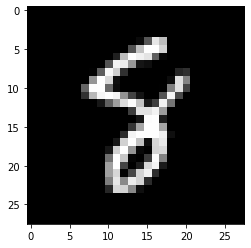

Prediction: 8


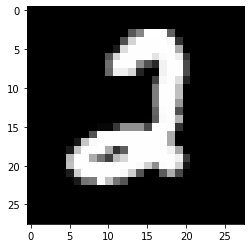

Prediction: 2


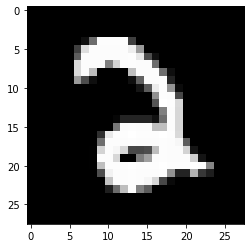

Prediction: 2


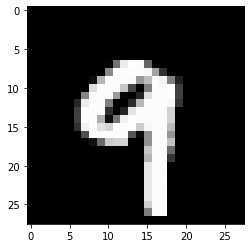

Prediction: 9


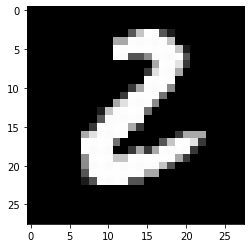

Prediction: 2


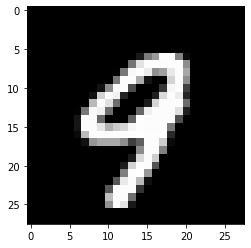

Prediction: 9


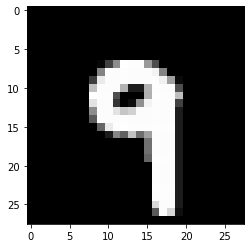

Prediction: 9


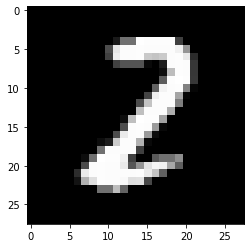

Prediction: 2


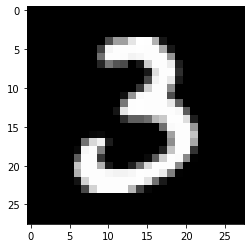

Prediction: 3


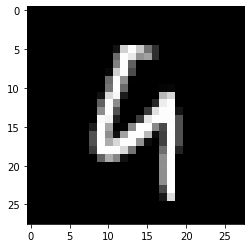

Prediction: 4


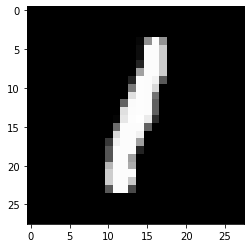

Prediction: 1


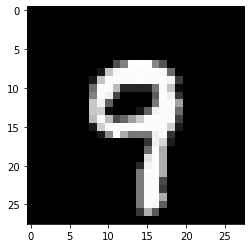

Prediction: 9


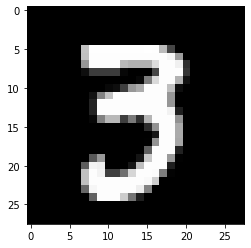

Prediction: 3


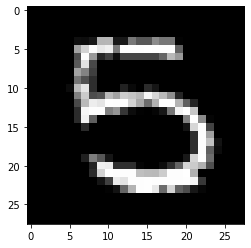

Prediction: 5


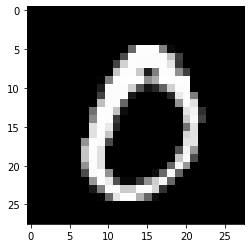

Prediction: 0


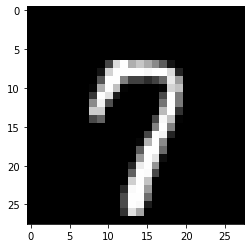

Prediction: 7


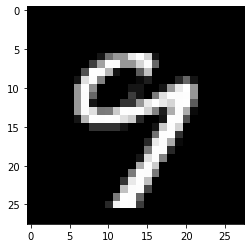

Prediction: 9


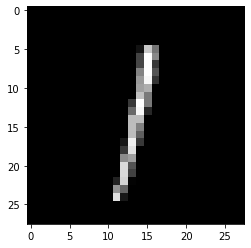

Prediction: 1


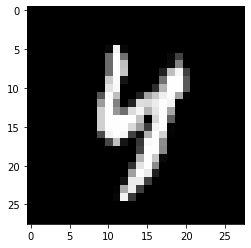

Prediction: 4


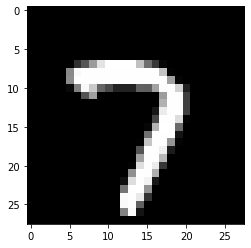

Prediction: 7


In [22]:
for i in random.sample(range(10000), 20):
  plt.imshow(test_images[i][0].reshape((28, 28)), cmap='gray')
  plt.show()
  print("Prediction:",predict_for_mnist(test_images[i][0], network))

That looks pretty good, right? Some images, especially when the digits are written a bit strange or fancy, are misclassified. Still, most of the time, the prediction should be correct.

But now, let's take a look at one of the biggest problems of neural networks. Let's repeat what we did above and look at the matrix between the second hidden layer and the output layer.

In [ ]:
weights, biases, activation_function, activation_function_prime = network

print(weights[2])

Do you see the difference? Can you see why this matrix now yields way better results than before training? Well, probably not, and most likely no one can. And that's a major problem of neural networks. They are very powerful, but their inner workings are nearly impossible to understand for humans without a lot of effort.

You can now go on and, for example, change the architecture of the neural network, e.g., to $[784, 64, 32, 10]$ and see if that improves the accuracy. Or you could try to build the network with a different activation function, e.g., $sigmoid$, and see what happens.

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

  
def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

## Ok, let's recap

With a couple of lines of code and without any prebuilt machine learning frameworks, we have created a neural network capable of classifying 95 out of 100 handwritten digits correctly. That is pretty impressive. Just try to think for a second of how you would have achieved something like this without a neural network.

This neural network could also be used for various other tasks, e.g., the classic dog vs. cats classification problem. We would just have to adapt the input layer to a different image size and change the output layer to only 2 neurons, one for dogs and one for cats. Still, this is probably the most basic architecture of a neural network. A lot of thinking went into creating more powerful and complex layers and architectures. You often have millions of parameters, which take weeks to train. These networks' results are often awe-inspiring, just look up the GPT-3 network for language processing or think of the self-driving cars by Tesla.

And yet, the basic principles we went through here are the same for all these networks.


## Thanks & Bye

Thank you so much if you made it all the way to here! I really hope that I could pass some of my fascination and enthusiasm for this topic on to you. And if some of the content here sticks with you and you have a rough understanding of how neural networks work, I am truly happy! :) If you want to give me feedback, just drop me a line at andreas.schwersenz at designit.com

## If you want to continue...

Here are some more links about the topic:

Very good, very detailed!

http://www.neuralnetworksanddeeplearning.com 

Also about implementing a neural network from scratch:

https://www.medium.com/datadriveninvestor/math-neural-network-from-scratch-in-python-d6da9f29ce65 

Another series about building neural networks from scratch:

https://towardsdatascience.com/https-medium-com-piotr-skalski92-deep-dive-into-deep-networks-math-17660bc376ba 

https://towardsdatascience.com/preventing-deep-neural-network-from-overfitting-953458db800a

https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795

https://towardsdatascience.com/how-to-train-neural-network-faster-with-optimizers-d297730b3713

And this is just the math of the derivatives mentioned above :)

https://medium.com/@pdquant/all-the-backpropagation-derivatives-d5275f727f60